## Importing Libraries

In [1]:
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

# Examples of recordings

## Neutral

In [234]:
import IPython.display as ipd
audio, sr = librosa.load('./audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')
Audio(data=audio, rate=sr)

Text(0.5, 1.0, 'Waveplot - Neutral')

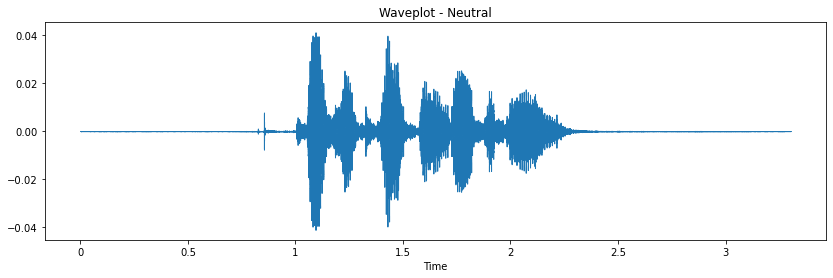

In [235]:
# waveplot
plt.figure(figsize=(14, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title('Waveplot - Neutral')

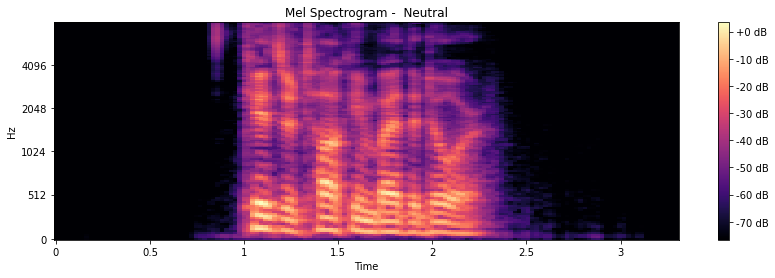

In [236]:
# CREATE LOG MEL SPECTROGRAM
melspectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128,fmax=8000) 
melspectrogram = librosa.power_to_db(melspectrogram)

plt.rcParams['figure.figsize'] = (14,4)
img_melspectrogram = librosa.display.specshow(melspectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram -  Neutral')
plt.colorbar(format='%+2.0f dB');

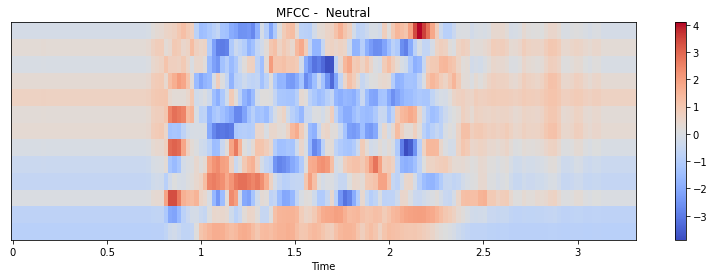

In [240]:
import sklearn
plt.rcParams['figure.figsize'] = (14,4)
mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)

img_MFCC = librosa.display.specshow(mfcc, x_axis='time')
plt.title('MFCC -  Neutral')
plt.colorbar()

## Stressed

In [249]:
audio, sr = librosa.load('./audio_speech_actors_01-24/Actor_01/03-01-06-02-02-01-01.wav')
Audio(data=audio, rate=sr)

Text(0.5, 1.0, 'Waveplot - Stressed')

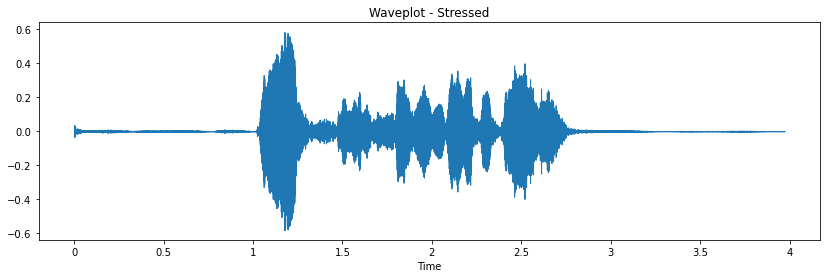

In [250]:
# waveplot
plt.figure(figsize=(14, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title('Waveplot - Stressed')

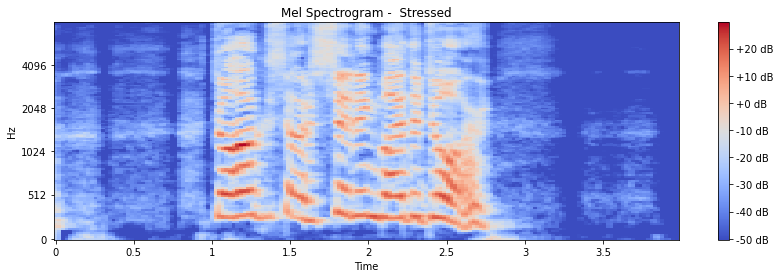

In [251]:
# CREATE LOG MEL SPECTROGRAM
melspectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128,fmax=8000) 
melspectrogram = librosa.power_to_db(melspectrogram)

plt.rcParams['figure.figsize'] = (14,4)
img_melspectrogram = librosa.display.specshow(melspectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram -  Stressed')
plt.colorbar(format='%+2.0f dB');

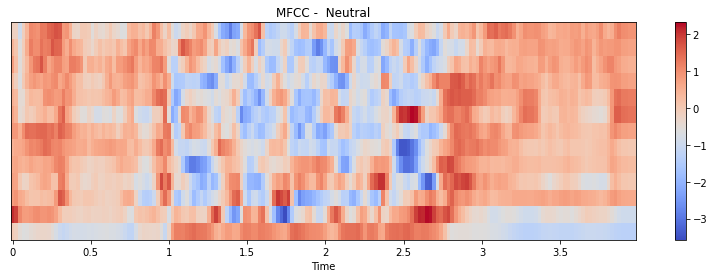

In [252]:
plt.rcParams['figure.figsize'] = (14,4)
mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)

img_MFCC = librosa.display.specshow(mfcc, x_axis='time')
plt.title('MFCC -  Neutral')
plt.colorbar()

## Loading data

In [120]:
# CREATE DIRECTORY OF AUDIO FILES 
audio = "./audio_speech_actors_01-24/"
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 

In [121]:
# CREATE FUNCTION TO EXTRACT EMOTION NUMBER
emotion = []
file_path = []
for i in actor_folders:
    filename = os.listdir(audio + i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        file_path.append(audio + i + '/' + f)

In [228]:
audio_df = pd.DataFrame(emotion)

In [229]:
audio_df.columns = ['emotion']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)

In [124]:
audio_df.sample(n=6)

,emotion,path
504,4,./audio_speech_actors_01-24/Actor_09/03-01-04-...
444,4,./audio_speech_actors_01-24/Actor_08/03-01-04-...
114,8,./audio_speech_actors_01-24/Actor_02/03-01-08-...
80,4,./audio_speech_actors_01-24/Actor_02/03-01-04-...
959,8,./audio_speech_actors_01-24/Actor_16/03-01-08-...
3,1,./audio_speech_actors_01-24/Actor_01/03-01-01-...


In [125]:
# 0 - non stressed 1 - stressed
audio_df['emotion'] = audio_df['emotion'].replace([1, 2, 3, 4, 5, 7, 8], 0)
audio_df['emotion'] = audio_df['emotion'].replace(6, 1)
audio_df.sample(n=10)


,emotion,path
597,0,./audio_speech_actors_01-24/Actor_10/03-01-08-...
499,0,./audio_speech_actors_01-24/Actor_09/03-01-03-...
238,0,./audio_speech_actors_01-24/Actor_04/03-01-08-...
643,1,./audio_speech_actors_01-24/Actor_11/03-01-06-...
675,0,./audio_speech_actors_01-24/Actor_12/03-01-03-...
1132,0,./audio_speech_actors_01-24/Actor_19/03-01-08-...
1016,0,./audio_speech_actors_01-24/Actor_17/03-01-08-...
184,0,./audio_speech_actors_01-24/Actor_04/03-01-02-...
354,0,./audio_speech_actors_01-24/Actor_06/03-01-08-...
1072,0,./audio_speech_actors_01-24/Actor_18/03-01-08-...


## Feature extraction

In [126]:
df = pd.DataFrame(columns=['mfcc'])

for index,path in enumerate(audio_df.path):
    audio, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    mfcc=np.mean(mfcc,axis=0)
    df.loc[index] = [mfcc]

In [127]:
df

,mfcc
0,"[-65.80097, -65.80097, -65.80097, -65.80097, -..."
1,"[-63.190464, -62.799866, -63.830635, -60.55258..."
2,"[-65.81886, -65.81886, -65.81886, -65.81886, -..."
3,"[-66.05848, -66.05848, -66.05848, -66.05848, -..."
4,"[-70.26777, -70.26777, -70.26777, -70.26777, -..."
...,...
1435,"[-58.98881, -58.98881, -60.665466, -60.689583,..."
1436,"[-54.67716, -54.67716, -54.67716, -54.67716, -..."
1437,"[-56.940815, -56.940815, -56.940815, -56.94081..."
1438,"[-55.255135, -55.255135, -55.18665, -55.345295..."


In [128]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_combined = pd.concat([audio_df,pd.DataFrame(df['mfcc'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)

In [129]:
df_combined.drop(columns='path', inplace=True)

In [130]:
df_combined

,emotion,0,1,2,3,4,5,6,7,8,...,249,250,251,252,253,254,255,256,257,258
0,0,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,-65.800972,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,-63.190464,-62.799866,-63.830635,-60.552586,-60.821678,-62.073399,-64.889229,-65.389946,-65.389946,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,-65.818863,-65.818863,-65.818863,-65.818863,-65.805527,-65.818863,-65.818863,-65.629539,-64.802628,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,-66.058479,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,-70.267769,...,-70.267769,-70.267769,-69.957710,-68.377602,-69.862564,-70.267769,-70.122139,-68.554955,-70.206528,-70.267769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0,-58.988811,-58.988811,-60.665466,-60.689583,-59.735569,-60.501480,-60.420517,-59.816250,-60.189262,...,-58.973309,-58.984501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1436,0,-54.677158,-54.677158,-54.677158,-54.677158,-54.677158,-54.677158,-54.677158,-54.677158,-54.677158,...,-54.624363,-54.677158,-54.677158,-54.156242,-54.677158,-54.677158,-54.115520,-54.271080,-54.677158,-54.636047
1437,0,-56.940815,-56.940815,-56.940815,-56.940815,-56.940815,-56.943363,-57.077030,-56.940815,-56.940815,...,-56.438938,-56.940815,-56.940815,-56.940815,-56.940815,-56.940815,-56.923138,-56.938293,-56.927471,-56.865555
1438,0,-55.255135,-55.255135,-55.186649,-55.345295,-55.053379,-53.088177,-52.199924,-52.218304,-52.633869,...,-49.756596,-50.436131,-49.073444,-49.137142,-51.701096,-54.797939,-55.255135,-54.609993,-52.202969,-51.720993


## Preparing data for modeling

In [215]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(df_combined, test_size=0.2, random_state=0,
                               stratify=df_combined[['emotion']])

In [217]:
X_train = train.iloc[:, 1:]
y_train = train.iloc[:,0]
print(X_train.shape)

(1152, 259)


In [218]:
X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]
print(X_test.shape)

(288, 259)


## Preprocessing

In [219]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [220]:
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

## Decison Tree

In [222]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)

0.7708333333333334

In [144]:
X_train.shape

(1152, 259)

## Random Forest

In [223]:
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier(criterion="gini", max_depth=10, max_features="log2", 
                                 max_leaf_nodes = 100, min_samples_leaf = 3, min_samples_split = 20, 
                                 n_estimators= 22000, random_state= 5)

In [224]:
rforest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='log2', max_leaf_nodes=100,
                       min_samples_leaf=3, min_samples_split=20,
                       n_estimators=22000, random_state=5)

In [225]:
rforest.predict(X_test)
rforest.score(X_test, y_test)

0.8819444444444444

In [258]:
!{sys.executable} -m pip install mglearn

  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582644 sha256=14f8892c63ef27953ee827a19fc3461a093e3d20b9d01aadc56afc9290dab3d5
  Stored in directory: c:\users\dominikmaciąg\appdata\local\pip\cache\wheels\df\30\8a\1e2c8f144c9d411b0688f628d496d2db8f61b6d14bcedaa1df
Successfully built mglearn


## CNN

In [145]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

#BUILD 1D CNN LAYERS
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(1, activation='sigmoid'))
opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss='BinaryCrossentropy', optimizer=opt,metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 250, 64)           704       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 30, 128)           0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 2, 128)           

In [146]:
# RESHAPE DATA TO INCLUDE 3D TENSOR 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

X_test.shape

(288, 259, 1)

In [147]:
X_train.shape

(1152, 259, 1)

In [148]:
y_train.shape

(1152,)

In [149]:
X_train

array([[[-1.09791382],
        [-1.17047609],
        [-1.17903194],
        ...,
        [-0.36330346],
        [-0.34479899],
        [-0.55375065]],

       [[-0.26851752],
        [-0.34194321],
        [-0.2688146 ],
        ...,
        [-0.87004411],
        [-0.87788286],
        [-0.87612467]],

       [[ 1.93837194],
        [ 1.89592948],
        [ 1.94524368],
        ...,
        [-0.04323085],
        [-0.05052074],
        [-0.05463457]],

       ...,

       [[-0.04202005],
        [ 0.05342309],
        [ 0.30944352],
        ...,
        [-0.79120028],
        [-0.75765149],
        [-0.81129863]],

       [[-0.0960001 ],
        [-0.15862343],
        [-0.14808332],
        ...,
        [ 1.55987482],
        [ 1.55364914],
        [ 1.53815006]],

       [[-1.3825936 ],
        [-1.45797989],
        [-1.47196159],
        ...,
        [-1.09113523],
        [-1.16131485],
        [-1.17333679]]])

In [150]:
import tensorflow.keras as keras

# FIT MODEL AND USE CHECKPOINT TO SAVE BEST MODEL
checkpoint = ModelCheckpoint("best_initial_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', period=1, save_weights_only=True)

model_history=model.fit(X_train, y_train,batch_size=32, epochs=40, validation_data=(X_test, y_test),callbacks=[checkpoint])

Epoch 1/40
36/36 [==============================] - 3s 44ms/step - loss: 0.9591 - binary_accuracy: 0.8542 - val_loss: 0.6768 - val_binary_accuracy: 0.8681
Epoch 2/40
36/36 [==============================] - 1s 35ms/step - loss: 0.5557 - binary_accuracy: 0.8663 - val_loss: 0.5071 - val_binary_accuracy: 0.8681
Epoch 3/40
36/36 [==============================] - 1s 35ms/step - loss: 0.4736 - binary_accuracy: 0.8663 - val_loss: 0.4585 - val_binary_accuracy: 0.8681
Epoch 4/40
36/36 [==============================] - 1s 35ms/step - loss: 0.4422 - binary_accuracy: 0.8663 - val_loss: 0.4221 - val_binary_accuracy: 0.8681
Epoch 5/40
36/36 [==============================] - 1s 36ms/step - loss: 0.4145 - binary_accuracy: 0.8663 - val_loss: 0.4103 - val_binary_accuracy: 0.8681
Epoch 6/40
36/36 [==============================] - 1s 35ms/step - loss: 0.4009 - binary_accuracy: 0.8663 - val_loss: 0.3993 - val_binary_accuracy: 0.8681
Epoch 7/40
36/36 [==============================] - 1s 36ms/step - los

Epoch 35/40
36/36 [==============================] - 1s 36ms/step - loss: 0.2818 - binary_accuracy: 0.8915 - val_loss: 0.3657 - val_binary_accuracy: 0.8785
Epoch 36/40
36/36 [==============================] - 1s 37ms/step - loss: 0.2940 - binary_accuracy: 0.8984 - val_loss: 0.3719 - val_binary_accuracy: 0.8854
Epoch 37/40
36/36 [==============================] - 1s 36ms/step - loss: 0.2795 - binary_accuracy: 0.8984 - val_loss: 0.3601 - val_binary_accuracy: 0.8854
Epoch 38/40
36/36 [==============================] - 1s 37ms/step - loss: 0.2742 - binary_accuracy: 0.8932 - val_loss: 0.3462 - val_binary_accuracy: 0.8924
Epoch 39/40
36/36 [==============================] - 1s 35ms/step - loss: 0.2884 - binary_accuracy: 0.8915 - val_loss: 0.3856 - val_binary_accuracy: 0.8819
Epoch 40/40
36/36 [==============================] - 1s 35ms/step - loss: 0.2866 - binary_accuracy: 0.8915 - val_loss: 0.3656 - val_binary_accuracy: 0.8611


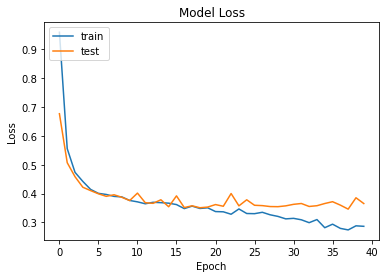

In [153]:
# # PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# plt.plot(model_history.history['binary_accurancy'])
# plt.plot(model_history.history['val_binary_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('Initial_Model_Accuracy.png')
# plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [156]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_history.history['binary_accurancy'])
plt.plot(model_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Initial_Model_Accuracy.png')
plt.show()

KeyError: 'binary_accurancy'

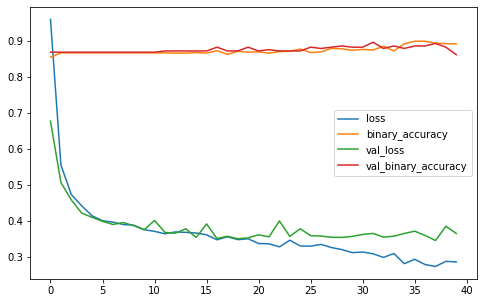

In [155]:
pd.DataFrame(model_history.history).plot(figsize=(8,5))
plt.show()

## Post-model analysis

In [157]:
# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

9/9 [==============================] - 0s 8ms/step - loss: 0.3656 - binary_accuracy: 0.8611
Loss of the model is -  0.3655712306499481
9/9 [==============================] - 0s 8ms/step - loss: 0.3656 - binary_accuracy: 0.8611
Accuracy of the model is -  86.11111044883728 %


In [212]:
# PREDICTIONS
predictions = model.predict(X_test)
predictions = np.rint(predictions)
predictions = predictions.flatten()
predictions = pd.DataFrame({'Predicted Values': predictions})

# # ACTUAL LABELS
actual=y_test
actual = actual.flatten()
# actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})
# actual
# # # COMBINE BOTH 
finaldf = actual.join(predictions)
finaldf[0:50]

array([[4.02078509e-01],
       [2.06472963e-01],
       [4.19905484e-01],
       [3.89844179e-04],
       [1.07263774e-01],
       [3.30217183e-02],
       [9.33332145e-02],
       [1.01824462e-01],
       [1.79714561e-01],
       [4.10895348e-02],
       [6.62446022e-02],
       [2.37599015e-03],
       [2.81201422e-01],
       [3.92808318e-02],
       [5.10123432e-01],
       [1.96829140e-01],
       [1.12274259e-01],
       [3.68409753e-02],
       [2.10759908e-01],
       [1.37720704e-02],
       [1.25294507e-01],
       [4.24729586e-02],
       [2.16868520e-02],
       [7.54446387e-02],
       [1.31788969e-01],
       [4.35534120e-02],
       [6.78869843e-01],
       [2.70082772e-01],
       [1.65158719e-01],
       [1.13475472e-01],
       [3.27292264e-01],
       [1.00261658e-01],
       [2.59856462e-01],
       [6.58774376e-01],
       [1.68837637e-01],
       [7.13739932e-01],
       [2.87664533e-01],
       [7.71954060e-01],
       [1.27158165e-02],
       [2.77446002e-01],


In [209]:
y_test

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [201]:
actual

,Actual Values
0,1
1,1
2,0
3,0
4,0
...,...
283,0
284,0
285,0
286,0


In [211]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

NameError: name 'lb' is not defined

<Figure size 864x720 with 0 Axes>